In [1]:
# NEURON simulator imports
from neuron import h
from neuron.units import mV, ms, sec, um
import LFPy

# other essential packages
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.gridspec import GridSpec
import re

In [2]:
%matplotlib inline

In [3]:
# c compiler
!nrnivmodl

/home/hanna/miniconda3/envs/lascon/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/hanna/Documents/studies/academies/2024-LASCON/project/synergisticDendrites
Mod files:

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [4]:
class Neuron():
    """
    Creates a NEURON cell instance with specific dendritic morphologies. Neurons can have passive or active
    somas and dendrites. They can be stimulated and return membrane potential recordings from pre- and post-
    synaptic stimulation sites and from the soma.
    
    Parameters
    ----------
    alpha (float): value between 0 and 1, indicating the pyramidal-likeness, as opposed to purkinje-likeness, 
                   of the dendritic morphology
    celsius (int): temperature in Celsius
    maxTreeLength (float): maximum length of dendritic tree in microns
    basalDendLength (float): length of basal dendrite; 
                             if between 0 and 1, then the absolute length of the basal dendrite is given by basalDendLength*maxTreeLength 
    Vrest (float): resting potential in mV
    Cmem (float): membrane capacitance in uF cm^-2
    Rmem (float): membrane resistance in Ohm
    Ra (flat): axial resistance in Ohmh.load_file("Purkinje19b972-1.nrn") 
    geo (dict): geometry-defining default parameters of soma and dendritic sections
    mech (dict): mechanisms of dendrite, soma and axon Sections ('pas' for passive, or 'hh' for Hodgekin-Huxley)
    """
    
    def __init__(self,
                 alpha=0.5,
                 celsius=6,
                 Vrest=-70*mV,
                 Cmem=0.638856,
                 Rmem=120236.0,
                 Ra=141.949,
                 maxTreeLength=300*um,
                 basalDendLength=0.3,
                 geo={'soma': {'L':12.6157*um, 'diam': 12.6157*um, 'nseg': 5}, 
                      'dendrite': {'L': 10*um, 'diam': 1*um, 'nseg': 5}},
                 mech={'dendrite': 'pas', 'soma': 'hh', 'axon': 'pas'}):
        
        # reset h before creating a new neuron
        h('forall delete_section()')
        self.h = h
        self.h.celsius = celsius
        
        # set biophysical parameters (in soma)
        self.Vrest = Vrest
        self.Cmem = Cmem
        self.Rmem = Rmem
        self.Ra = Ra
        self.mech = mech

        # geometry defining parameters
        self.geo = geo
        self.alpha = alpha
        self.maxTreeLength = maxTreeLength
        self.basalDendLength = basalDendLength if basalDendLength>1 else basalDendLength*maxTreeLength

        # create storage variables
        self.dendrites = []    # array of dendrite sections
        self.dist2soma = []    # distance of dendrite sections to the soma
        self.synapses = []     # array of synapses

        # create soma, define its geometry and biophysics
        self.soma = self.createSection('soma')
        self.growDendrites()

    def __repr__(self):
        return "Neuron"

    def __str__(self):
        return "aNeuron"

    def createSection(self, type):
        """
        Returns a neuron section with type-specific mechanism and biophysical parameters.
        """
        # create NEURON Section instance
        num = len(self.dendrites)
        sec = h.Section(name=type+"["+str(num)+"]", cell=self)
        
        # define Section geometry
        sec.L = self.geo[type]['L']
        sec.diam = self.geo[type]['diam']
        sec.nseg = self.geo[type]['nseg']
        
        # define biophysics
        sec.insert(self.mech[type])
        sec.Ra = self.Ra
        sec.cm = self.Cmem
        
        # set passive biophysical parameters
        if self.mech[type]=='pas':
            sec.e_pas = self.Vrest
            sec.g_pas = (1/self.Rmem)
            
        # set hodgekin huxley biophysical parameters
        elif self.mech[type]=='hh':
            sec.gnabar_hh = 0.12  # Sodium conductance in S/cm2
            sec.gkbar_hh = 0.036  # Potassium conductance in S/cm2
            sec.gl_hh = 0.0003    # Leak conductance in S/cm2
            sec.el_hh = -54.3     # Reversal potential in mV

        return sec

    def addBranch(self, parent):
        """
        Creates a new dendrite section and connects it to the end of the parent. Returns dendrite section.
        """
        # create new dendrite section
        dend = self.createSection('dendrite')
        dend.connect(parent(1), 0)
        
        # store the distance of the starting point of the new dendrite from the soma
        dist = 0 if not self.dendrites else self.dist2soma[self.getDendIdx(parent)]+parent.L
        self.dist2soma.append(dist)
            
        # add dendrite to list
        self.dendrites.append(dend)
            
        return dend

    def growDendrites(self, root=None):
        """
        Grows dendritic tree from a given parent section.
        Parameters:
        -----------
        root (NEURON Section): parent section from where to grow the dendritic tree from. If None, then root=self.soma. 
        """
        # if neuron has no dendrites yet, create one and connect to soma
        if not self.dendrites:
            root = self.addBranch(self.soma)
        elif not root:
            root = self.dendrite[-1]
            
        # initialize queue with new roots that can grow into branches
        roots = [[root]]   
        count = 0
        maxCount = 500

        while roots and count<maxCount:
            # pick a root and make it the current branch
            currentBranch = roots[-1]
            branchLength = len(currentBranch)*self.geo['dendrite']['L']
            del roots[-1]
            
            # extend branch until it has reached maximum length
            while branchLength<self.maxTreeLength:
                # add a new dendrite section
                dend = self.addBranch(currentBranch[-1])
                
                # check if bifurcation occurs 
                if np.random.rand()<self.getBranchProb(branchLength):
                    # connect sister branch to parent
                    sister = self.addBranch(currentBranch[-1])
                    # add sister branch to new roots
                    roots.append(currentBranch+[sister])
                    
                # add first branch to current branch list
                currentBranch.append(dend)
                
                # update branchLength
                branchLength += self.geo['dendrite']['L']
                count += 1

    def getBranchProb(self, dist2soma):
        """ Returns branching probability, given the distance of the potential branching point from the soma. """
        return 1-self.alpha

    def createSynapse(self, dendIdx, loc=0.5, tau=[2*ms, 4*ms], e=0*mV):
        """ Returns an excitatory synapse on the dendrite given by Idx. """
        # create synapse and set parameters
        syn = self.h.Exp2Syn(self.dendrites[dendIdx](loc))
        syn.tau1 = tau[0]
        syn.tau2 = tau[1]
        syn.e = e
        self.synapses.append(syn)
        return syn 
        
    def createStim(self, isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
        """ Returns a NetStim object. """
        stim = self.h.NetStim()
        stim.interval = isi
        stim.number = num
        stim.start = start
        stim.noise = noise
        stim.noiseFromRandom123(seed, 0, 0)
        stim.seed(seed)
        return stim

    def connectStim(self, syn, stim, delay=1*ms, weight=0.4):
        """ Connects stimulation (NetStim instance) to synapse and returns the connection (NetConn instance). """
        conn = self.h.NetCon(stim, syn)
        conn.delay = delay
        conn.weight[0] = weight
        return conn
    
    def simulate(self, dendIdx, seed=9, dt=0.01,
                 loc=0.5, tau=[2*ms, 4*ms], e=0*mV, 
                 isi=20*ms, num=100, start=1*ms, stop=1000*ms, noise=1, 
                 delay=1*ms, weight=0.4, 
                 numApicalSyn=10):
        """
        Runs a full simulation of stimulating the Neuron and returns recordings from soma, inputs, dendrites and synapses.
        Parameters:
        dendIdx (array): array of indices of dendrites with basal inputs that are considered as PID sources
        seed (int): random seed of first basal input; every n-th additional input/ synapse has seed = seed + n
        dt (float): integration time step
        loc, tau, e (float): synapse parameters
        isi, num, start, stop, noise (int, int, int, int, float): NetStim parameters
        delay, weight (float): basal input connection weights
        numApicalSyn (int): number of apical inputs
        """
        # get number of inputs
        numInputs = len(dendIdx)
        
        # create basal synapses, stimulations, and connections
        synapses = [self.createSynapse(dendIdx[i], loc=loc, tau=tau, e=e) for i in range(numInputs)]
        stimulations = [self.createStim(isi=isi, num=num, start=start, noise=noise, seed=seed+i) for i in range(numInputs)]
        connections = [self.connectStim(synapses[i], stimulations[i], delay=delay, weight=weight) for i in range(numInputs)]

        # create apical synapses, stimulations and connections
        seed = seed+numInputs-1
        apicalDendIdx = np.random.choice(self.getApicalDendIdx(), size=numApicalSyn) # could add seed here as well
        apicalSyns = [self.createSynapse(apicalDendIdx[i], loc=loc, tau=tau, e=e) for i in range(numApicalSyn)]
        apicalStims = [self.createStim(isi=isi, num=num, start=start, noise=noise, seed=seed+i) for i in range(numApicalSyn)]
        apicalConns = [self.connectStim(apicalSyns[i], apicalStims[i], delay=delay, weight=weight) for i in range(numApicalSyn)]
        
        # prepare output variable
        recordings = {'soma': self.h.Vector(),
                      'input': [self.h.Vector() for i in range(numInputs)],
                      'inputTime': [self.h.Vector() for i in range(numInputs)],
                      'dendrite': [self.h.Vector() for i in range(numInputs)],
                      'synapse': [self.h.Vector() for i in range(numInputs)],
                      'time': self.h.Vector(), 
                      'basalSynapses': synapses,
                      'apicalSynapses': apicalSyns}
        
        # set up recordings
        recordings['soma'].record(self.soma(0.5)._ref_v) # soma membrane potential
        recordings['time'].record(self.h._ref_t) # time steps
        for i, dend in enumerate(dendIdx):
            recordings['dendrite'][i].record(self.dendrites[dend](0.5)._ref_v)
            recordings['synapse'][i].record(synapses[i]._ref_i)
            connections[i].record(recordings['inputTime'][i], recordings['input'][i])

        # run simulation
        self.h.dt = dt # set integration time step
        self.h.load_file('stdrun.hoc')
        self.h.finitialize(self.Vrest)
        self.h.continuerun(stop) 
        
        # convert outputs into numpy arrays
        for k,v in recordings.items():
            if k in ['soma', 'time']:
                recordings[k] = np.array(list(recordings[k]))
            elif k in ['input', 'inputTime', 'dendrite', 'synapse']:
                recordings[k] = [np.array(list(recordings[k][i])) for i in range(len(recordings[k]))]
        
        return recordings

    def getApicalDendIdx(self):
        """ Returns indices of all apical dendrite sections in self.dendrites."""
        return [i for i in range(len(self.dendrites)) if self.dist2soma[i]>self.basalDendLength]

    def getBasalDendIdx(self):
        """ Returns indices of all basal dendrite sections in self.dendrites. """
        return [i for i in range(len(self.dendrites)) if self.dist2soma[i]<=self.basalDendLength]

    def getDendIdx(self, dend):
        """ Returns index of dendrite section within self.dendrites. """
        return int(re.search(r'\[(.*?)\]', dend.__repr__()).group(1))

    def isDendrite(self, sec):
        """ Returns True if sec is a dendrite section. """
        return 'dend' in sec.name()

    def plot(self, synapses=[], ax=None):
        """ Plots the dendritic morphology of the neuron. """
        # get the section list from the neuron
        sl = self.h.SectionList([sec for sec in h.allsec()])
        
        # pass section list to LFPy Cell object
        cell = LFPy.Cell(sl)
    
        # plot the dendritic tree
        if not ax:
            fig = plt.figure(figsize=(12, 12))    
            ax = fig.add_subplot(121, aspect=1, xticks=[], xlabel='x [µm]', ylabel='y [µm]')
        else:
            ax.set_xlabel('x [µm]')
            ax.set_ylabel('y [µm]')

        # plot dendrites
        ax.plot(cell.y.T, cell.x.T, c='k')
    
        # plot synapses
        for syn in synapses:
            # find index of dendrite of that synapse, and location on dendrite
            loc = syn.get_loc()
            dendIdx = self.getDendIdx(syn.get_segment())
            
            # plot basal synapses in red, and apical in blue
            style = 'ro' if self.dist2soma[dendIdx]<=self.basalDendLength else 'bo'
            x = sum(cell.x[dendIdx])*loc
            y = sum(cell.y[dendIdx])*loc
            ax.plot(y, x, style)
    

In [5]:
def plotAll(cell, recordings):
    # get some parameters for convenience
    numInputs = len(recordings['input'])
    stop = recordings['time'][-1]
    
    # generate colours for different inputs
    cmap = cm.get_cmap('winter')
    spacing = cmap.N//numInputs
    colours = cmap(np.arange(0, cmap.N, spacing))
    
    # define figure panels
    fig = plt.figure(figsize=(15, 7))
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.5)
    gs = GridSpec(4, 3, figure=fig)
    
    # rasterplot with input stimuli
    ax1 = fig.add_subplot(gs[0, :-1])
    for i in range(numInputs):
        ax1.vlines(recordings['inputTime'][i], i-0.4, i+0.4, colors=colours[i])  
    ax1.set_yticks(range(len(recordings['input'])))
    ax1.set_xlim(0, stop)
    ax1.set_xlabel('time (ms)')
    ax1.set_ylabel('input id')
    
    # plot membrane potential of soma
    ax2 = fig.add_subplot(gs[1, :-1])
    ax2.plot(recordings['time'], recordings['soma'], color='r', label='soma')
    ax2.set_xlim(0, stop)
    ax2.set_xlabel('time (ms)')
    ax2.set_ylabel('soma Vmem (mV)')

    # plot membrane potential of dendrites
    ax3 = fig.add_subplot(gs[2, :-1])
    for i in range(numInputs):
        ax3.plot(recordings['time'], recordings['dendrite'][i], color=colours[i], label='dendrite'+str(i))
    ax3.set_xlim(0, stop)
    ax3.set_xlabel('time (ms)')
    ax3.set_ylabel('dendrite Vmem (mV)')
    
    # sanity check: plot synapse current
    ax4 = fig.add_subplot(gs[3, :-1])
    for i in range(numInputs):
        ax4.plot(recordings['time'], recordings['synapse'][i], color=colours[i])
    ax4.set_xlim(0, stop)
    ax4.set_xlabel('time (ms)')
    ax4.set_ylabel('synapse I (mA)')

    # plot neuron morphology
    ax5 = fig.add_subplot(gs[:, -1])
    cell.plot(ax=ax5, synapses=recordings['basalSynapses']+recordings['apicalSynapses'])
    

In [6]:
def plotRecordings(recordings):
    # get some parameters for convenience
    numInputs = len(recordings['input'])
    stop = recordings['time'][-1]
    
    # generate colours for different inputs
    cmap = cm.get_cmap('winter')
    spacing = cmap.N//numInputs
    colours = cmap(np.arange(0, cmap.N, spacing))
    
    # create figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 7))
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
    
    # rasterplot with input stimuli
    for i in range(numInputs):
        ax1.vlines(recordings['inputTime'][i], i-0.4, i+0.4, colors=colours[i])  
    ax1.set_yticks(range(len(recordings['input'])))
    ax1.set_xlim(0, stop)
    ax1.set_xlabel('time (ms)')
    ax1.set_ylabel('input id')
    
    # plot membrane potential of soma
    ax2.plot(recordings['time'], recordings['soma'], color='r', label='soma')
    ax2.set_xlim(0, stop)
    ax2.set_xlabel('time (ms)')
    ax2.set_ylabel('soma Vmem (mV)')

    # plot membrane potential of dendrites
    for i in range(numInputs):
        ax3.plot(recordings['time'], recordings['dendrite'][i], color=colours[i], label='dendrite'+str(i))
    ax3.set_xlim(0, stop)
    ax3.set_xlabel('time (ms)')
    ax3.set_ylabel('dendrite Vmem (mV)')
    
    # sanity check: plot synapse current
    for i in range(numInputs):
        ax4.plot(recordings['time'], recordings['synapse'][i], color=colours[i])
    ax4.set_xlim(0, stop)
    ax4.set_xlabel('time (ms)')
    ax4.set_ylabel('synapse I (mA)')

In [7]:
def simulate_and_plot(dt=0.01,
                      alpha=0,                                                             # neuron parameters
                      celsius=37,                                              
                      Vrest=-70*mV,                                              
                      Cmem=0.638856,                                             
                      Rmem=120236.0,                                              
                      Ra=141.949,                                                  
                      maxTreeLength=300*um,
                      basalDendLength=0.5,
                      geo={'soma': {'L':12.6157*um, 'diam': 12.6157*um, 'nseg': 5}, 
                           'dendrite': {'L': 10*um, 'diam': 1*um, 'nseg': 5}},      
                      mech={'dendrite': 'pas', 'soma': 'hh', 'axon': 'pas'}, 
                      loc=0.5,                                                             # synapse parameters
                      tau=[2*ms, 4*ms],   
                      e=0*mV,
                      isi=20*ms,                                                           # stimulation parameters
                      num=100,
                      start=1*ms,
                      stop=1000*ms,
                      noise=1, 
                      delay=1*ms,                                                          # connection parameters
                      weight=0.4,
                      dendIdx=[None, None],                                                # simulation parameters
                      seed=9, 
                      numApicalSyn=5):
    
    # create neuron
    cell=Neuron(alpha=alpha, 
                celsius=celsius, 
                Vrest=Vrest, 
                Cmem=Cmem, 
                Rmem=Rmem, 
                Ra=Ra, 
                maxTreeLength=maxTreeLength, 
                basalDendLength=basalDendLength,
                geo=geo, 
                mech=mech) 

    # generate dendrite indices, if not set
    if not all(dendIdx):
        dendIdx = np.random.choice(cell.getBasalDendIdx(), size=len(dendIdx))
    print("stimulating dendrites: " + ', '.join(map(str, dendIdx)))

    # run simulation and get recordings
    recordings = cell.simulate(dendIdx, seed=seed,
                               loc=loc, tau=tau, e=e, 
                               isi=isi, num=num, start=start, stop=stop, noise=noise, 
                               delay=delay, weight=weight, numApicalSyn=numApicalSyn)
    
    #plotRecordings(recordings)
    plotAll(cell, recordings)

    return cell, recordings

In [8]:
# CHANGE PARAMETERS HERE

# neuron parameters
neuronParams = dict(alpha=0.5,                                                    # pyramidal-cell-likeness of the dendritic tree
                    celsius=6,                                                    # temperature of the neuron [Celsius]
                    Vrest=-70*mV,                                                 # resting potential [mV]
                    Cmem=0.638856,                                                # membrane capacitance of the soma [S]
                    Rmem=120236.0,                                                # membrane resistance of the soma [Ohm]
                    Ra=141.949,                                                   # axial resistance of the soma [Ohm]
                    maxTreeLength=300*um,                                         # maximum length of dendritic paths from soma [microns]
                    basalDendLength=0.5,                                          # length of basal part of dendrite 
                    geo={'soma': {'L':12.6157*um, 'diam': 12.6157*um, 'nseg': 5}, # geometry-defining params
                         'dendrite': {'L': 10*um, 'diam': 1*um, 'nseg': 5}},      
                    mech={'dendrite': 'pas', 'soma': 'hh', 'axon': 'pas'})        # biophysical mechanisms

# synapse (Exp2Syn) parameters
synParams = dict(loc=0.5,            # synapse location on the dendrite (0.5 for middle, if nseg is odd)
                 tau=[2*ms, 4*ms],   # synaptic time constants
                 e=0*mV)             # synapse reversal potential

# input stimulus (NetStim) parameters
stimParams = dict(isi=70*ms,         # mean interspike time interval
                  num=10,            # average number of spikes
                  start=1*ms,        # stimulus start time
                  stop=1000*ms,      # simulation stop time
                  noise=1)           # noise parameter (must be a value from 0 to 1)

# connection (NetConn) parameters
connParams = dict(delay=1*ms,        # connection delay
                  weight=0.05)       # connection weight

# simulation parameters
numInputs = 2                                                     # number of basal input simuli 
simParams = dict(dendIdx=[None for i in range(numInputs)],        # indices of dendrites where to inject the stimulus ('None' for random)   
                 seed=np.random.randint(10000),                   # random seeds of input stimulus noise
                 dt=0.01,                                         # numerical integration step
                 numApicalSyn=5)                                  # number of apical synapses (background noise)

stimulating dendrites: 692, 8


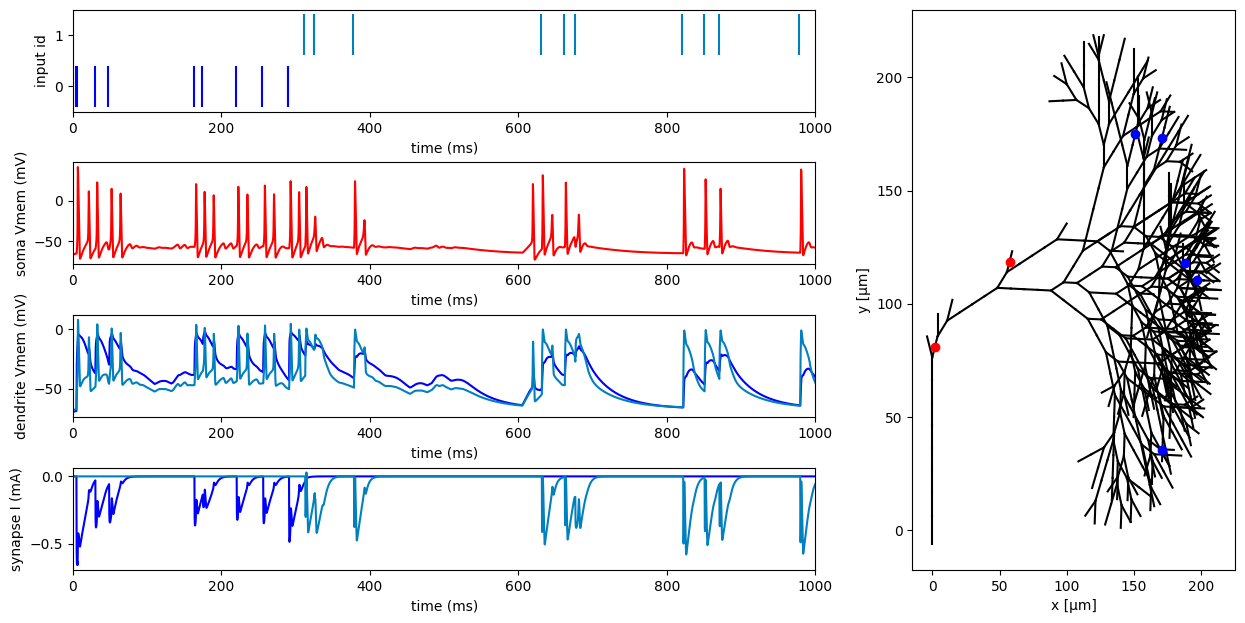

In [9]:
# run simulation and plot
cell, recording = simulate_and_plot(**neuronParams, **synParams, **stimParams, **connParams, **simParams)

# Measure PID atoms in artificial cells

In [25]:
alphas = np.arange(0, 1.1, 0.1) # branching probabilities alpha
numCells = 10                   # number of cells per alpha


### To do
- allow for creating a Neuron instance from biological morphologies
- check biophysical parameters
- function to create multiple neurons with varying alpha parameter, simulate them with background noise and record 2 apical inputs, obtain 2 source + 1 target time series from each run, 